# Stack Overflow Dataset

In [336]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline
import time
from matplotlib.pyplot import GridSpec
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
filename = '/Dataset/2016 Stack Overflow Survey Responses.csv'

In [4]:
# Let's preview dataset
from os import getcwd, listdir, chdir

df = pd.read_csv(getcwd() + filename)

def reset_df():
    """This function reverts the dataset into the original"""
    global df
    df = pd.read_csv(getcwd() + filename)
    
print df.shape
print df.head()

(56030, 66)
   Unnamed: 0 collector      country   un_subregion     so_region age_range  \
0        1888  Facebook  Afghanistan  Southern Asia  Central Asia     20-24   
1        4637  Facebook  Afghanistan  Southern Asia  Central Asia     30-34   
2       11164  Facebook  Afghanistan  Southern Asia  Central Asia       NaN   
3       21378  Facebook  Afghanistan  Southern Asia  Central Asia       NaN   
4       30280  Facebook  Afghanistan  Southern Asia  Central Asia      > 60   

   age_midpoint                  gender  \
0          22.0                    Male   
1          32.0                    Male   
2           NaN                     NaN   
3           NaN                  Female   
4          65.0  Prefer not to disclose   

                                 self_identification              occupation  \
0                                         Programmer                     NaN   
1                    Developer; Engineer; Programmer  Mobile developer - iOS   
2             

In [54]:
# I'd like to observe an arbitrary column and analyze the categories within
c = 'developer_challenges'
df[c].groupby(df[c]).count()

developer_challenges
Changing requirements                                                                                                                                                    142
Changing requirements; Limited resources                                                                                                                                  84
Changing requirements; Limited resources; Trying to be nice                                                                                                               10
Changing requirements; Trying to be nice                                                                                                                                   7
Changing requirements; Unspecific requirements                                                                                                                           204
Changing requirements; Unspecific requirements; Limited resources                                                 

# Understanding the columns and extracting the target columns for predictions

## There are a few things I'd like to do for a general plan:

1 Look at and understand the data

2 Break the dataset into a few mini projects, first starting with one mini project. 

3 Take a few columns as features, and use them for as the target column for each prediction

4 Mine and separate useful data into features to make different predictions:

    prediction 1 will use feature columns A - E
    
    prediction 2 will use feature columns F - P
    
    prediction 3 will use feature columns Q - X
    
4 Find patterns in the data, then trim the dataset as needed to find more patterns in the data

5 Make predictions, such as predict if a person is looking for a new job, and contact them.


example columns to use for the first prediction: 
'open_to_new_job', 'open_to_new_job', 'new_job_value', 'agree_loveboss', 'important_variety', 'important_newtech'

I'd like to understand more about the people who are currently working. Can we determine groups of people and their personalities, based on the importance of the workplace questions? From there, can we determine if those different types of people are looking for a new job? Can an ideal company be created to optimize worker happiness (of course, there are tradeoffs)?

By looking at the columns, I'll choose features that I think are important and list the reasons alongside them.
'age_range'           - does age determine if the person is looking for a                         new job?
'experience_range'    - does their level of experience encourage them to                           hop around to different companies?
'programming_ability' - this is not just a measure of their perceived                             ability but also a measure of their confidence 
'agree_loveboss'      - can they tolerate their bosses easily
'important_variety'   - would they rather switch roles often or do they                           prefer to stay with a specialty
'important_control'   - i hypothesize that this relates to b
'important_promotion' - do they care about promotions? i know some would                           rather be coding
'important_newtech'   - 
'important_companymission' - do they care about this much?
'important_buildexisting' - i think this would be the opposite of working                             with a variety of projects
'important_buildnew'  - build new?
'important_wfh'       - would this really matter?
'developer_challenges'- are there certain things that developers could do                         without?
'new_job_value'       - important about new employment opportunity, this                           is important to know
'tech_want'           - 
'education'           - 
'industry'            - 
'agree_notice'        - this shows how some brains work
'agree_nightcode'     - because these guys are a different type of animal
'occupation'          - 

I'm going to combine these to create a new dataframe then use the .dropna() function to remove unnecessary data to see if the data isn't reduced down too much.

From there, we will use PCA for feature extraction in order to focus on the really important ones

Process:
• Combine data into one DataFrame
• drop entries and columns with too many NaN values
• features: expand certain features
• label: vectorize the entries

In [6]:
# Combine all columns into one dataframe
work_xp = ['age_range', 'experience_range', 'programming_ability', 'agree_loveboss',
           'important_variety', 'important_control', 'important_promotion',
           'important_newtech', 'important_companymission', 'important_buildexisting',
           'important_buildnew', 'important_wfh', 'developer_challenges',
           'new_job_value', 'education', 'occupation', 'open_to_new_job']

# create a dataframe template
work_xp_df = pd.DataFrame(index=df.index)

# combine the selected columns into the new dataframe
for col in work_xp:
    work_xp_df = pd.concat([work_xp_df, df[col]], axis=1)
    
original = work_xp_df
original_shape = work_xp_df.shape # shape before dropping NaN entries
# remove the NaN entries
work_xp_df = work_xp_df.dropna()
reduced = work_xp_df.shape # shape after dropping NaN entries

# equation to calculate the percent change
percent_change = float((original_shape[0] - reduced[0])) / float(original_shape[0]) * 100
print "Using the .dropna() function reduces the data by {:.2f}% to these dimensions {}\n".format(percent_change, reduced)

print "Number of NaN entries per column: "
for col in original:
    print col, pd.isnull(original[col]).sum()

# I'd like to come back to this, and see if the ML algos can use this dataset with NaN values

Using the .dropna() function reduces the data by 35.40% to these dimensions (36197, 17)

Number of NaN entries per column: 
age_range 303
experience_range 6510
programming_ability 9048
agree_loveboss 13934
important_variety 13402
important_control 13458
important_promotion 13547
important_newtech 13426
important_companymission 13501
important_buildexisting 13450
important_buildnew 13492
important_wfh 13448
developer_challenges 14934
new_job_value 12372
education 11075
occupation 6511
open_to_new_job 11650


In [7]:
work_xp_df

,age_range,experience_range,programming_ability,agree_loveboss,important_variety,important_control,important_promotion,important_newtech,important_companymission,important_buildexisting,important_buildnew,important_wfh,developer_challenges,new_job_value,education,occupation,open_to_new_job
1,30-34,6 - 10 years,7.0,Agree somewhat,This is very important,This is very important,This is somewhat important,This is very important,This is somewhat important,I don't care about this,This is very important,I don't care about this,Unrealistic expectations; Interacting with non...,Salary; Ability to make or influence important...,I'm self-taught; On-the-job training; B.S. in ...,Mobile developer - iOS,I am not interested in new job opportunities
7,25-29,1 - 2 years,7.0,Agree completely,This is very important,This is very important,This is very important,This is very important,This is very important,This is very important,This is very important,I don't care about this,Non-technical management; Poor infrastructure ...,Salary; Company size; Job title,B.S. in Computer Science (or related field),Back-end web developer,"I'm not actively looking, but I am open to new..."
9,20-24,1 - 2 years,3.0,Neutral,This is very important,This is somewhat important,This is very important,This is very important,This is somewhat important,This is somewhat important,This is very important,This is somewhat important,Poor documentation,Tech stack; Opportunity for advancement,I'm self-taught; On-the-job training; Online c...,Back-end web developer,"I'm not actively looking, but I am open to new..."
11,20-24,6 - 10 years,9.0,Agree completely,This is somewhat important,This is very important,This is very important,This is very important,This is very important,This is somewhat important,This is very important,This is somewhat important,Poor team dynamics; Inefficient development pr...,Salary; Company stage; Work/life balance; Oppo...,"I'm self-taught; Online class (e.g. Coursera, ...",Full-stack web developer,"I'm not actively looking, but I am open to new..."
12,25-29,6 - 10 years,7.0,Neutral,This is somewhat important,This is very important,This is very important,This is very important,This is very important,This is somewhat important,This is very important,This is somewhat important,Poor scheduling; Interacting with stupid peopl...,Salary; Opportunity for advancement; Job title,B.S. in Computer Science (or related field),Full-stack web developer,I am actively looking for a new job
13,25-29,6 - 10 years,8.0,Disagree somewhat,This is somewhat important,This is somewhat important,This is somewhat important,This is very important,This is somewhat important,This is somewhat important,This is very important,This is somewhat important,Poor team dynamics; Inefficient development pr...,Salary; Company size; Company financials; Work...,I'm self-taught; On-the-job training; Masters ...,Back-end web developer,I am actively looking for a new job
14,20-24,1 - 2 years,7.0,Agree completely,I don't care about this,This is very important,This is very important,This is very important,This is very important,This is very important,This is very important,This is very important,Trying to be nice,Salary; Equity; Ability to make or influence i...,I'm self-taught; On-the-job training,Back-end web developer,I am not interested in new job opportunities
19,25-29,6 - 10 years,9.0,Neutral,This is somewhat important,This is somewhat important,This is very important,This is somewhat important,This is very important,This is very important,This is very important,This is somewhat important,Poor team dynamics; Interacting with stupid pe...,Salary; Remote working option; Flexible work h...,Masters Degree in Computer Science (or related...,Desktop developer,"I'm not actively looking, but I am open to new..."
20,20-24,2 - 5 years,6.0,Agree completely,This is very important,This is very important,This is somewhat important,This is very important,This is very important,This is very important,This is very im

# Next, split columns into features and label columns

In [8]:
# dataset of the features
feature_cols = work_xp_df.columns[:min(*work_xp_df.shape) - 1]
# dataset of the label column
label_col = work_xp_df.columns[-1]

print work_xp_df[label_col].groupby(work_xp_df[label_col]).count()

print feature_cols

open_to_new_job
I am actively looking for a new job                              5538
I am not interested in new job opportunities                     7439
I'm not actively looking, but I am open to new opportunities    23220
dtype: int64
Index([u'age_range', u'experience_range', u'programming_ability',
       u'agree_loveboss', u'important_variety', u'important_control',
       u'important_promotion', u'important_newtech',
       u'important_companymission', u'important_buildexisting',
       u'important_buildnew', u'important_wfh', u'developer_challenges',
       u'new_job_value', u'education', u'occupation'],
      dtype='object')


# The columns need to be vectorized and normalized, since they are currently formatted into categories, objects, and strings

The label column has three entries: [“I am not interested in new job opportunities”, “I’m not actively looking, but I am open to new opportunities”, “I am actively looking for a new job”]. I'd have to convert "I am not interested in new job opportunities" to have a value of 0 and the other two entries to a value of 1.

The feature columns are more complicated, since each are formatted differently. The features need to be categorized into different groups, based on how they need to be vectorized. Then we need to call a function on each of those groups to get the DataFrame's final desired format.

One challenge I'm thinking of is that the vectorized columns are unable to be inverse-transformed, meaning once ['red', 'white', 'blue'] is turned into [0, 1, 2], will we need to label the vectors ['red', 'white', 'blue'] for identifying the entries in the column.

In [9]:
# vectorize label column

mapper = {"I am not interested in new job opportunities": 0,
          "I'm not actively looking, but I am open to new opportunities": 1,
          "I am actively looking for a new job": 1}

label = pd.DataFrame(work_xp_df[label_col].map(mapper))

print label

       open_to_new_job
1                    0
7                    1
9                    1
11                   1
12                   1
13                   1
14                   0
19                   1
20                   1
21                   0
22                   0
23                   1
24                   1
26                   1
31                   1
32                   1
33                   1
34                   1
36                   1
37                   1
39                   1
40                   1
41                   1
42                   1
44                   1
45                   0
46                   1
48                   1
49                   1
51                   1
...                ...
55980                1
55981                1
55983                1
55984                1
55985                1
55986                1
55987                0
55988                1
55990                1
55991                0
55993                1
55994      

In [10]:
# before vectorizing the feature columns, we'll take a look at how all of them are formatted
features = work_xp_df[feature_cols]

print features[features.columns[0:5]]
print features.education

      age_range  experience_range  programming_ability       agree_loveboss  \
1         30-34      6 - 10 years                  7.0       Agree somewhat   
7         25-29       1 - 2 years                  7.0     Agree completely   
9         20-24       1 - 2 years                  3.0              Neutral   
11        20-24      6 - 10 years                  9.0     Agree completely   
12        25-29      6 - 10 years                  7.0              Neutral   
13        25-29      6 - 10 years                  8.0    Disagree somewhat   
14        20-24       1 - 2 years                  7.0     Agree completely   
19        25-29      6 - 10 years                  9.0              Neutral   
20        20-24       2 - 5 years                  6.0     Agree completely   
21        20-24       2 - 5 years                  9.0     Agree completely   
22         < 20  Less than 1 year                  4.0  Disagree completely   
23        20-24       2 - 5 years                  7

age_range: the age_range needs to be vectorize

experience_range: vectorize

programming_ability: vectorize

agree_loveboss: vectorize

important_variety: vectorize

important_contro: vectorize

important_companymission: vectorize

important_buildexisting: vectorize

important_buildnew: vectorize

important_wfh: vectorize

developer_challenges: convert to binary columns

new_job_value: convert to binary columns

education: convert to binary columns

occupation: vectorize

## the columns that need to be vectorized are converting the entries to numbers range(0, n)
## the columns that need to be converted to binary columns have multiple answers

We'll create two functions for these two groups

In [33]:
# this is a list of all the columns that need to be broken down further
large_columns = ['occupation',
                 'education',
                 'new_job_value',
                 'developer_challenges',
                 'age_range',
                 'experience_range']

In [88]:
# this function uses the LabelEncoder() to convert entries into numeric values
def vectorize_data(df, col):
    # BUG: it reorders the row indices into [1, 2, 3, 4, 5, ...] 
    # instead of maintaining the indices[1, 7, 9, 11, 12, 13, ...]
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(df[col])
    vectorized = le.transform(df[col])
    
    return pd.DataFrame(vectorized, columns=[col])


# i'm going to create another function that removes the bug
def vectorize_data2(df, col):
    # first create the mapper
    mapper = {}
    counter = 0
    for idx, entry in df[col].iteritems():
        if entry not in mapper and not pd.isnull(entry):
            mapper[entry] = counter
            counter += 1
            
    return pd.DataFrame(df[col].map(mapper))


# this function splits the multiple answers into all columns and inputs binary entries
def convert_to_binary_columns(df, column_name):
    a = df[column_name].str.get_dummies(sep='; ')
    return a


# this main function uses the converters above to transform the entire dataset
def main_transform_columns(df):
    outX = pd.DataFrame(index=df.index)
    
    binary = ["developer_challenges", "new_job_value", "education"]
    for col in df.columns:
        if col in binary:
            expanded_col = convert_to_binary_columns(df, col)
            outX = outX.join(expanded_col)
        else:
            col = vectorize_data2(df, col)
            outX = outX.join(col)
            
    return outX


# BUG: NaN entries
cleaned_features = main_transform_columns(features)
print cleaned_features.head(10)

    age_range  experience_range  programming_ability  agree_loveboss  \
1           0                 0                    0               0   
7           1                 1                    0               1   
9           2                 1                    1               2   
11          2                 0                    2               1   
12          1                 0                    0               2   
13          1                 0                    3               3   
14          2                 1                    0               1   
19          1                 0                    2               2   
20          2                 2                    4               1   
21          2                 2                    2               1   

    important_variety  important_control  important_promotion  \
1                   0                  0                    0   
7                   0                  0                    1   
9           

(36197, 16)


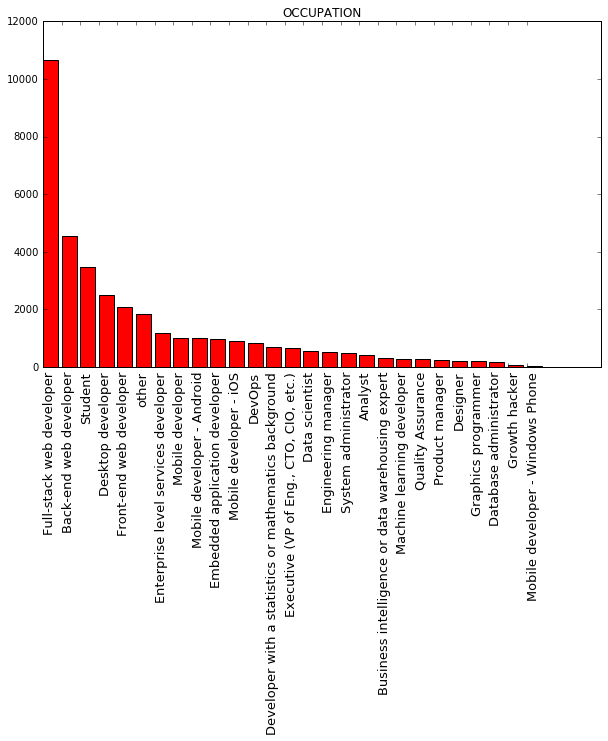

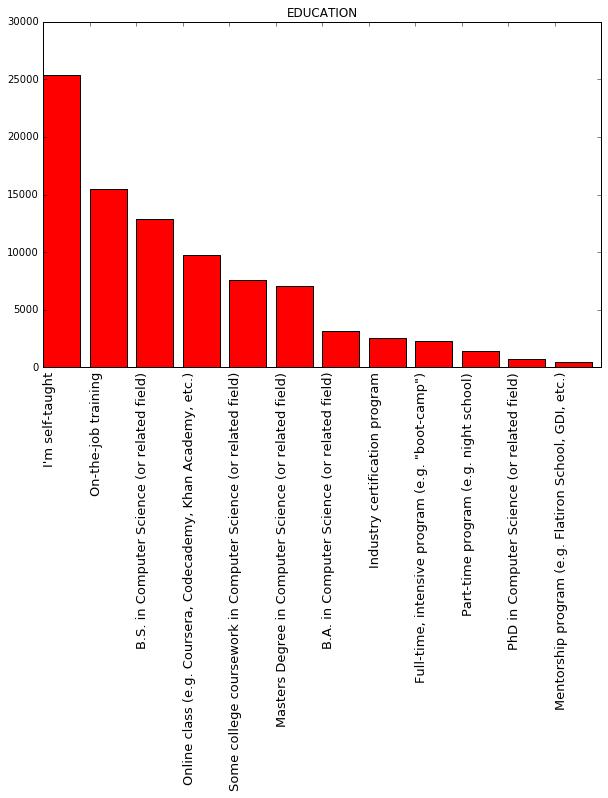

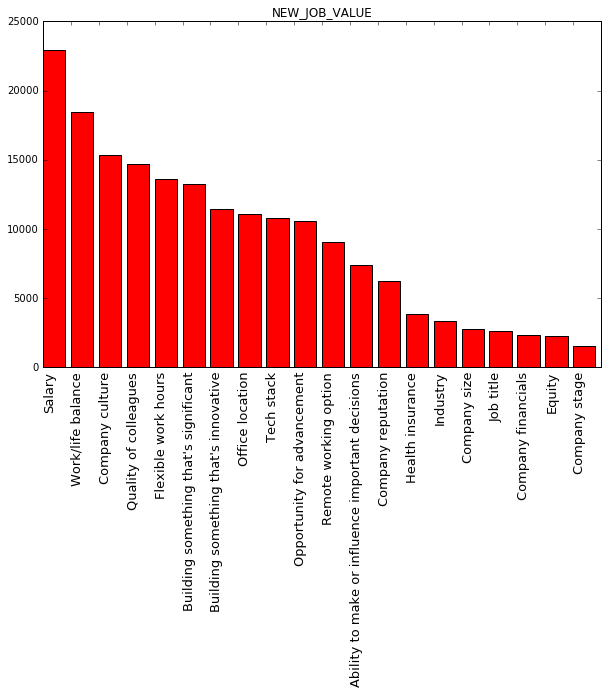

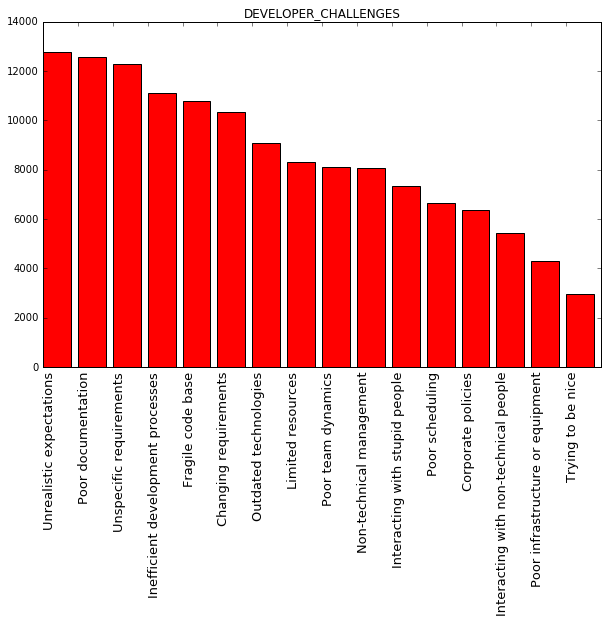

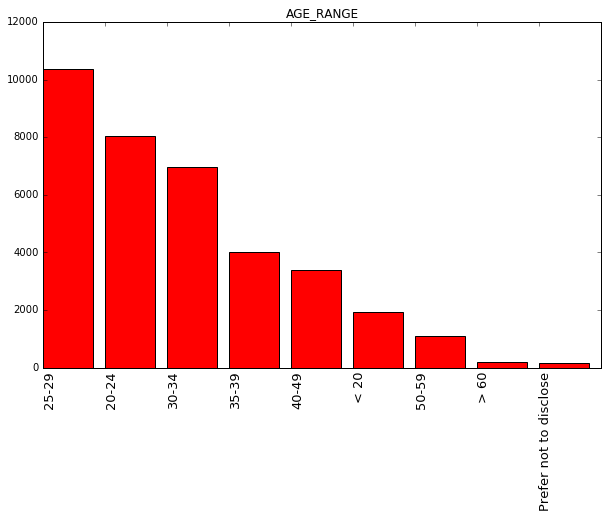

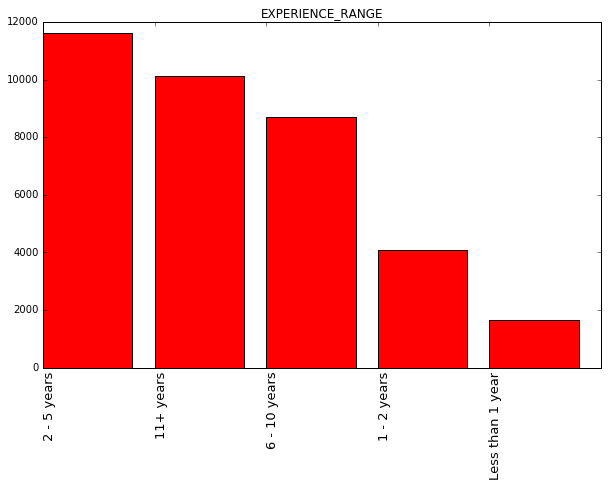

In [89]:
def class_name(objct):
    return objct.__class__.__name__

# make bar graphs
def plot_axes(df, column_name):
    if class_name(df) == 'DataFrame':
        bernoulli_df_sum = convert_to_bernoulli_columns(df, column_name).sum()
    elif class_name(df) == 'Series':
        bernoulli_df_sum = df
        
    bernoulli_df_sum.sort_values(inplace=True, 
                                 ascending=False,
                                 na_position='first')
    x = bernoulli_df_sum.index
    y = bernoulli_df_sum
    
    return x, y, column_name

def plot_bernoulli_df((x, y, column_name)):
    ind = np.arange(len(y))

    pl.figure(figsize=(10,8))
    pl.title("{}".format(column_name.upper()))
    pl.bar(np.arange(len(x)),
           y.values,
           color='r',
           tick_label=list(x))
    pl.xticks(np.arange(len(x)), list(x), rotation='vertical', fontsize=13, horizontalalignment='left')
    pl.subplots_adjust(bottom=0.30)
    pl.show()

# plot bar graphs of each of the listed columns, using the functions above
# c = 'occupation'
# print features[c].groupby(features[c]).count()
print features.shape
for column in large_columns:
    sub_df = plot_bernoulli_df((plot_axes(features, column)))

In [66]:
cleaned_features.columns

Index([u'age_range', u'experience_range', u'programming_ability',
       u'agree_loveboss', u'important_variety', u'important_control',
       u'important_promotion', u'important_newtech',
       u'important_companymission', u'important_buildexisting',
       u'important_buildnew', u'important_wfh', u'Changing requirements',
       u'Corporate policies', u'Fragile code base',
       u'Inefficient development processes',
       u'Interacting with non-technical people',
       u'Interacting with stupid people', u'Limited resources',
       u'Non-technical management', u'Outdated technologies',
       u'Poor documentation', u'Poor infrastructure or equipment',
       u'Poor scheduling', u'Poor team dynamics', u'Trying to be nice',
       u'Unrealistic expectations', u'Unspecific requirements',
       u'Ability to make or influence important decisions',
       u'Building something that's innovative',
       u'Building something that's significant', u'Company culture',
       u'Company fina

In [67]:
# It looks like this is a more appropriate algorithm to not change the indices
vectorize_data2(features, features.columns[0])

,age_range
1,0
7,1
9,2
11,2
12,1
13,1
14,2
19,1
20,2
21,2


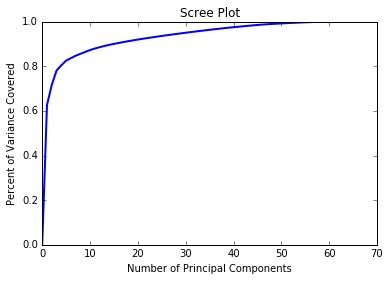

None
[ 0.62613962  0.71622713  0.78082565  0.80423106  0.82507155  0.83644981
  0.8469577   0.85570547  0.86422223  0.87252709  0.87936171  0.88536899
  0.89070809  0.8957739   0.90014431  0.90440833  0.90844857  0.91229779
  0.91596652  0.91954682  0.92300008  0.92625232  0.92945287  0.93260746
  0.93573389  0.93873301  0.94162008  0.94448404  0.94727891  0.95004355
  0.95276872  0.9554671   0.95811172  0.96069402  0.96326663  0.96570048
  0.96810615  0.97047171  0.97274443  0.97488854  0.97699855  0.97905141
  0.98105267  0.98303758  0.98495271  0.98657283  0.98807019  0.98941587
  0.99064217  0.99183339  0.99294245  0.99400352  0.99502363  0.99592123
  0.99676975  0.9976044   0.99838053  0.99896154  0.999509    0.99981711
  1.        ]


In [68]:
# use PCA to reduce the data into lower dimensions
from sklearn.decomposition import PCA


def feature_components_evr(feature_columns):
    pca = PCA(n_components=min(*feature_columns.shape))
    pca.fit(feature_columns)
    
    return pca.components_, pca.explained_variance_ratio_
    
    
def scree_plot(evr):
    """Used to determine the number of components to use for PCA"""
    evr = np.concatenate([[0], evr])
    cum_evr = np.cumsum(evr)
    
    pl.figure()
    pl.title("Scree Plot")
    pl.plot(cum_evr, lw=2, label="Cumulative Explained Variance Ratio")
    pl.xlabel("Number of Principal Components")
    pl.ylabel("Percent of Variance Covered")
    pl.show()

fce = feature_components_evr(cleaned_features)

print scree_plot(fce[1])
print np.cumsum(fce[1])

## Based on the scree plot, above, I decided to use 3 principal components
To hypertune and modify the data later, I'll try it with 4 principal components

## Now, I'll scale and reduce the data. The data will only have the feature columns, leaving out the label column.
Before scaling, we need to take a look at the distribution of data for each column

Also, I'd like to analyze which features are correlated with each other 

In [69]:
def plot_column((x, y, column_name)):
    # plot a bar graph
    idx = np.arange(len(y))

    pl.figure(figsize=(10,8))
    pl.title("{}".format(column_name.upper()))
    pl.bar(np.arange(len(x)),
           y.values,
           color='r',
           tick_label=list(x))
    pl.xticks(np.arange(len(x)), list(x), rotation='vertical')
    pl.subplots_adjust(bottom=0.15)
    pl.show()


print cleaned_features[cleaned_features.columns[0]]
    
for col, data in cleaned_features.iteritems():
    m = np.mean(data)
    sd = np.std(data)
#     print data.groupby(data).count().index
    # bug, the index names aren't aligned with the data
#     print data.groupby(data).count()
#     print plot_column(())

1        0
7        1
9        2
11       2
12       1
13       1
14       2
19       1
20       2
21       2
22       3
23       2
24       2
26       4
31       2
32       1
33       1
34       2
36       2
37       0
39       1
40       2
41       1
42       1
44       2
45       0
46       2
48       1
49       5
51       3
        ..
55980    1
55981    0
55983    1
55984    5
55985    0
55986    5
55987    0
55988    0
55990    0
55991    0
55993    0
55994    4
55996    2
55997    7
55998    5
55999    0
56000    1
56001    0
56002    5
56003    5
56004    4
56005    4
56006    2
56007    2
56009    1
56012    0
56014    0
56019    5
56022    1
56029    2
Name: age_range, dtype: int64


In [70]:
from sklearn.preprocessing import StandardScaler

first_pc = feature_components_evr(cleaned_features)[0][0]
second_pc = feature_components_evr(cleaned_features)[0][1] 
third_pc = feature_components_evr(cleaned_features)[0][2]

cleaned_features = cleaned_features[cleaned_features.columns[:-2]]
original_data = cleaned_features
# scale to a distribution with mean = 0 and sd = 1
# bad with data that isn't normally distributed, can be a problem with categorized data that turned into vectors
# might have to change the scaling method later
scaled_data = StandardScaler().fit_transform(cleaned_features)
# reduce data, using 4 principal components
reduced_data = PCA(n_components=3).fit_transform(cleaned_features)
# reduced and scaled
reduced_scaled_data = StandardScaler().fit_transform(reduced_data)

print "Original data: {} rows, {} columns".format(*original_data.shape)
print "Scaled data: {} rows, {} columns".format(*scaled_data.shape)
print "Reduced data: {} rows, {} columns".format(*reduced_data.shape)
print "Reduced and scaled data: {} rows, {} columns".format(*reduced_scaled_data.shape)
print "First PC: {}".format(first_pc[:5])
print "Second PC: {}".format(second_pc[:5])
print "Third PC: {}".format(third_pc[:5])

Original data: 36197 rows, 59 columns
Scaled data: 36197 rows, 59 columns
Reduced data: 36197 rows, 3 columns
Reduced and scaled data: 36197 rows, 3 columns
First PC: [ 0.01119528  0.00947554  0.01515544 -0.00049852 -0.00156531]
Second PC: [  2.86470445e-01   2.01487018e-01   9.35439029e-01   1.95002744e-02
   4.77947483e-04]
Third PC: [ 0.80118869  0.47966864 -0.3512693   0.01681907  0.0048617 ]


## Now, I'd like to visualize the reduced data and observe the principal components

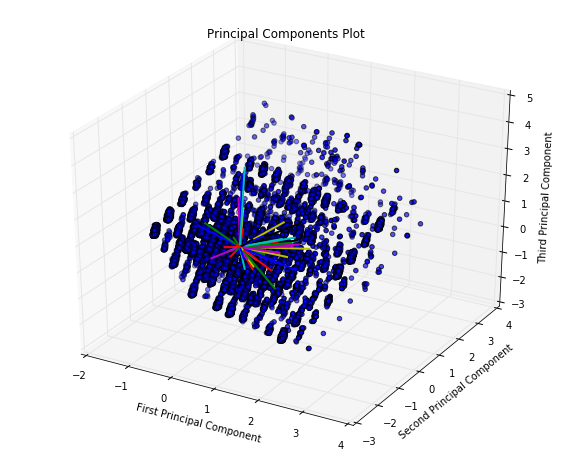

In [344]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.font_manager import FontProperties
%matplotlib inline


scaled_pca = PCA(n_components=3).fit(scaled_data)
first_scaled_pc = [x*5 for x in scaled_pca.components_[0]]
second_scaled_pc = [y*5 for y in scaled_pca.components_[1]]
third_scaled_pc = [z*5 for z in scaled_pca.components_[2]]

scaled_pcs = [first_scaled_pc, second_scaled_pc, third_scaled_pc]

# plot in 3d
def plot_pc_data(features, scaled_pcs):
    x = features[:, 0]
    y = features[:, 1]
    z = features[:, 2]
    
    fig = pl.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("Principal Components Plot")
    
    # plotting data points
    ax.scatter(x, y, z, 'k.')
    # plotting pc vectors
    for i, j in enumerate(original_data.columns):
        ax.plot(xs=[0, scaled_pcs[0][i]], ys=[0, scaled_pcs[1][i]], zs=[0, scaled_pcs[2][i] ], lw=2, label=j)
#         ax.annotate(original_data.columns, (scaled_pcs[0][i], scaled_pcs[1][i], scaled_pcs[2][i]), markersize=2)
        
    ax.set_xlabel("First Principal Component")
    ax.set_ylabel("Second Principal Component")
    ax.set_zlabel("Third Principal Component")
    
    ax.auto_scale_xyz(x, y, z)
    pl.show()

# use data reduced down to three dimensions
plot_pc_data(reduced_scaled_data, scaled_pcs)

# Cross Validation

In [346]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(cleaned_features, label, test_size=0.2)

# Classification

In [322]:
# features, pd.DataFrame(label)
from sklearn.svm import SVC

features = cleaned_features

clf = SVC(C=0.1, gamma=0.1)

t1 = time.time()
clf.fit(X_train, y_train)
t2 = time.time()

pred = clf.predict(X_test)
t3 = time.time()

print "Training time: {}".format(t2 - t1)
print "Prediction time: {}".format(t3 - t2)
print "F1 Score: {}".format(f1_score(y_test, pred))

/Applications/Code/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


Training time: 228.65555501
Prediction time: 15.3819789886
F1 Score: 0.887009992314


In [140]:
# I'd like to explore the parameter combinations of the svm classifier to analyze any significant increase in the F1 score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score)
params = {'C': [0.1*c for c in range(1,3)],
          'gamma': [0.1*g for g in range(1,5)]}

clf = SVC()
clf.fit(X_train, y_train)

gs_svm = GridSearchCV(clf, param_grid=params, scoring=scorer)
gs_svm.fit(features, label[label.columns[-1]])

print gs_svm.best_estimator_
print gs_svm.best_score_
print gs_svm.best_params_

/Applications/Code/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.885474558977
{'C': 0.1, 'gamma': 0.1}


In [76]:
print scaled_data.shape
print cleaned_features.shape

(36197, 59)
(36197, 59)


# The classifier is working way too well, with an f1 score of .999

I'm going to fit the data with a decision tree and check which features have been 

In [199]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

t1 = time.time()
rfc.fit(X_train, y_train)
t2 = time.time()

rfc_pred = rfc.predict(X_test)
t3 = time.time()

rfc_f1 = f1_score(y_test, rfc_pred)
print "Training time: {}".format(t3 - t2)
print "Prediction time: {}".format(t2 - t1)
print "F1 Score: {}".format(rfc_f1)

/Applications/Code/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Training time: 0.0264339447021
Prediction time: 0.43169593811
F1 Score: 0.86602755176


## Random Forests is a lot quicker. I'd like to hypertune the parameters and try to beat the svm classifier's score

## I might use Spark to run the svm's grid search algorithm

In [213]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# param ranges were narrowed down from original, but still within range of the best estimator,
# in order to save gridsearch algorithm running time
params = {'n_estimators': range(13, 17),
          'criterion': ['gini', 'entropy'],
          'min_samples_split': range(1, 3),
          'min_samples_leaf': range(7, 10)}
scorer = make_scorer(f1_score)
est = RandomForestClassifier()
est.fit(X_train, y_train)

X = pd.concat([X_train, X_test], axis=0)
y = pd.Series(pd.concat([y_train, y_test], axis=0))

gs = GridSearchCV(est, param_grid=params, scoring=scorer)
gs.fit(features, label[label.columns[-1]])

print gs.best_estimator_
print gs.best_score_
print gs.best_params_

/Applications/Code/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=9, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.885782268464
{'min_samples_split': 1, 'n_estimators': 15, 'criterion': 'gini', 'min_samples_leaf': 9}


In [260]:
# input the optimal parameters into the classifier
rfc = RandomForestClassifier(min_samples_split=1, 
                             n_estimators=15, 
                             criterion='gini', 
                             min_samples_leaf=9)

t1 = time.time()
rfc.fit(X_train, y_train)
t2 = time.time()
rfc_pred = rfc.predict(X_test)
t3 = time.time()

rfc_f1 = f1_score(y_test, rfc_pred, pos_label=1)
print "Training time: {}".format(t3 - t2)
print "Prediction time: {}".format(t2 - t1)
print "F1 Score: {}".format(rfc_f1)

# analyze the most important features that help make the best predictions
rfc_fi_ = pd.Series(rfc.feature_importances_, index=cleaned_features.columns)
rfc_fi_ = rfc_fi_.sort_values(ascending=False)

/Applications/Code/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Training time: 0.0196950435638
Prediction time: 0.477514982224
F1 Score: 0.887315270936


In [333]:
from sklearn.metrics import classification_report

print "Random Forests:"
print classification_report(y_test, rfc_pred, labels=[1, 0])
print "\nSupport Vector Machine:"
print classification_report(y_test, pred, labels=[1, 0])

Random Forests:
             precision    recall  f1-score   support

          1       0.80      1.00      0.89      5770
          0       0.24      0.00      0.01      1470

avg / total       0.68      0.80      0.71      7240


Support Vector Machine:
             precision    recall  f1-score   support

          1       0.80      1.00      0.89      5770
          0       0.00      0.00      0.00      1470

avg / total       0.64      0.80      0.71      7240



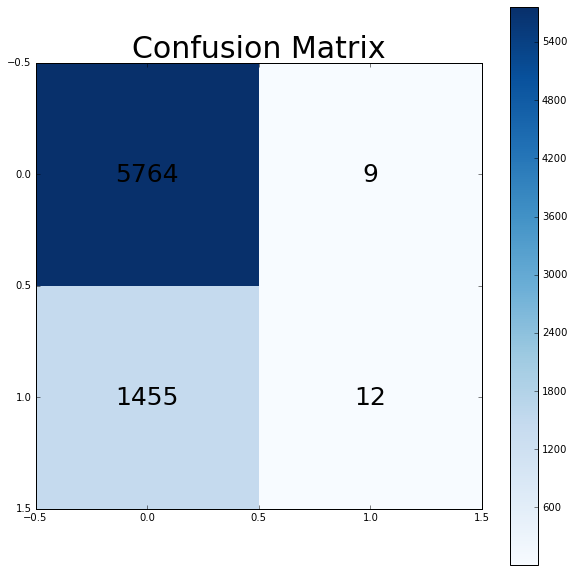

In [319]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
%matplotlib inline

# copied and pasted then modded from stackoverflow question to obtain
def perf_measure(y_actual, y_hat):
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    
    for i in range(len(y_hat)):
        if y_actual[i][0] == y_hat[i] == 1:
            tp += 1
        elif y_actual[i][0] == 1 and y_actual[i][0] != y_hat[i]:
            fp += 1
        elif y_actual[i][0] == 0 and y_actual[i][0] != y_hat[i]:
            fn += 1
        elif y_actual[i][0] == y_hat[i] == 0:
            tn += 1
            
    return (tp, fp, fn, tn)

cm = confusion_matrix(y_test, rfc_pred, labels=[1, 0])

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=pl.cm.Blues):
    pl.figure(figsize=(10, 10))
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.colorbar()
    pl.title("Confusion Matrix", size=30)
    for x in range(0,2):
        for y in range(0, 2):
            pl.annotate(str(cm[x][y]), xy = (y, x),
                        horizontalalignment='center', 
                        verticalalignment='center',
                        size=25)

plot_confusion_matrix(cm)

In [192]:
print "Feature importances:\n\n{}".format(rfc_fi_[:10])

Feature importances:

agree_loveboss              0.128273
age_range                   0.047261
programming_ability         0.046929
important_promotion         0.042203
experience_range            0.041071
important_wfh               0.029203
important_companymission    0.027298
important_newtech           0.024786
important_control           0.023427
important_buildexisting     0.022653
dtype: float64


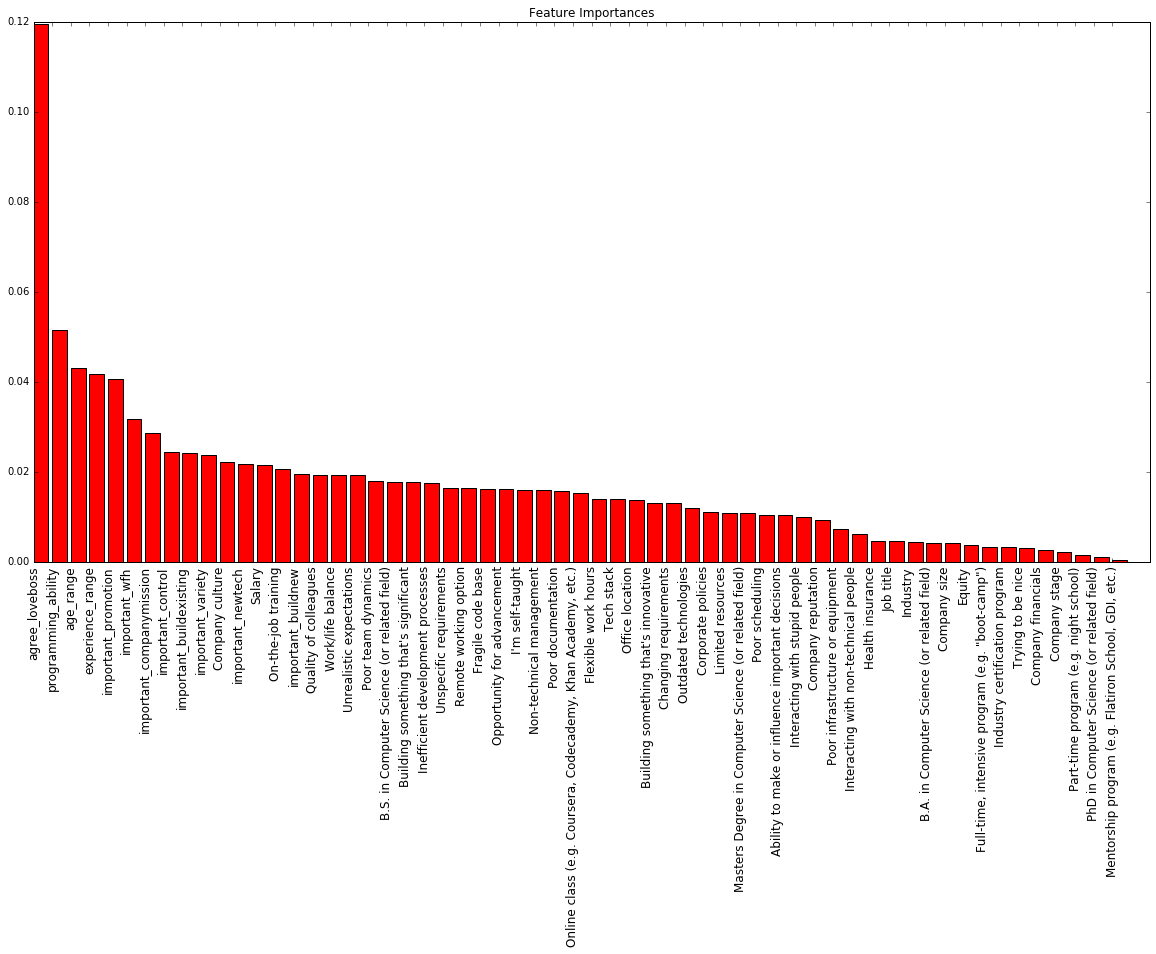

In [82]:
# plotting feature importances in descending order
pl.figure(figsize=(20,10))
pl.title("Feature Importances")
pl.bar(np.arange(len(rfc_fi_.index)),
       rfc_fi_.values,
       color='r',
       tick_label=list(rfc_fi_.index))
pl.xticks(np.arange(len(rfc_fi_.index)), list(rfc_fi_.index), rotation='vertical', fontsize=12)
pl.subplots_adjust(bottom=0.15)

In [114]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
params = {'booster': 'gbtree', 'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }

tree_booster_params = {'eta': 1, 'gamma': 1, 'min_child_weight': 1, 'max_depth': 3}
watchlist  = [(dtest,'eval'), (dtrain,'train')]

num_round = 3
bst = xgb.train(params, dtrain, num_boost_round=num_round)
preds = bst.predict(dtest)
labels = dtest.get_label()

print ('error=%f' % ( sum(1 for i in range(len(preds)) if int(preds[i]>0.5)!=labels[i]) /float(len(preds))))

# dtrain.feature_names

# help('xgboost.DMatrix')

error=0.206630


In [185]:
# Here, I'd like to visualize the number of different answers for each column
# I'd like to make a subplot for each column after cleaning, and look at the data by frequency
cols = df.columns
total_cols = len(cols)

col_data_dict = {}
# leaving out cols[0] because it is an ID column
for col, data in df[cols[1:]].iteritems():
    print df[col].groupby(df[col]).count()

collector
Facebook                     9811
House ads                    8633
Meta Stack Overflow Post    28177
Miscellaneous                 108
Reddit                       6226
Twitter                      3075
dtype: int64
country
Afghanistan                48
Albania                    34
Algeria                    38
Andorra                    12
Angola                     10
Antarctica                  1
Antigua & Deps              2
Argentina                 362
Armenia                    35
Australia                1117
Austria                   482
Azerbaijan                 29
Bahamas                     7
Bahrain                    11
Bangladesh                166
Barbados                    3
Belarus                   164
Belgium                   543
Belize                      2
Benin                       2
Bermuda                     2
Bhutan                      2
Bolivia                    15
Bosnia Herzegovina         54
Botswana                    4
Brazil         

## The following columns need to be broken down:

'self_identification'

'tech_do'

'tech_want'

'dev_environment'

'education'

'new_job_value'

'how_to_improve_interview_process'

'developer_challenges'

'why_stack_overflow'

## Removing NaN entries
There are multiple ways to remove NaN entries.
One way to remove NaN values is with the .dropna() function. However, this function can remove too many values, so I looked at the percentage decrease of data by using this function. The sklearn.preprocessing.Imputer function won't work for the label column.

In [188]:
# we'll break down education and take a look at it here
def plot_axes(df, column_name):
    if df.__class__.__name__ == 'DataFrame':
        bernoulli_df_sum = convert_to_bernoulli_columns(df, column_name).sum()
    elif df.__class__.__name__ == 'Series':
        bernoulli_df_sum = df
        
    bernoulli_df_sum.sort_values(inplace=True, 
                                 ascending=False,
                                 na_position='first')
    x = bernoulli_df_sum.index
    y = bernoulli_df_sum
    
    return x, y, column_name

def plot_bernoulli_df((x, y, column_name)):
    ind = np.arange(len(y))

    pl.figure(figsize=(10,8))
    pl.title("{}".format(column_name.upper()))
    pl.bar(np.arange(len(x)),
           y.values,
           color='r',
           tick_label=list(x))
    pl.xticks(np.arange(len(x)), list(x), rotation='vertical')
    pl.subplots_adjust(bottom=0.15)
    pl.show()
    
edu_sum = convert_to_bernoulli_columns(df, 'education').sum()

## Need to recombine the expanded columns into the original dataset

The original dataset should have (12 + 42 + 42 + 23 + 12 + 20 + 9 + 16 + 10 - 9) more columns.

In [11]:
edu_df = convert_to_bernoulli_columns(df, 'education')

In [186]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.mixture import GMM

pipe_lr = Pipeline([("scl", StandardScaler()),
                    ("pca", PCA()),
                    ("gmm", GMM())
                ])

pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=None, whiten=False)), ('gmm', GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0))])

In [190]:
# Reduce the data into the necessary amount of dimensions
# Scale the data to find a correlation among the variables
pipe_lr.score(X_test, y_test)

array([-80.89847253, -74.32967353, -71.61493557, ..., -76.54780089,
       -90.40464955, -70.81135511])

# The Target/Label column(s)

First, we have to categorize the target column(s):

Is it a single column or multiple columns?

Is it a classification or regression?


In [87]:
# for the target column we need to vectorize it
# the target column is also

sw_vs_st = df['star_wars_vs_star_trek']


def transform_labels(target_col):
    le = LabelEncoder()
    le.fit(target_col)
    return le.transform(target_col)


def transform_labels_except_nan(target_col):
    print target_col.shape
    mapper = {"Star Wars": 1,
              "Star Trek": 2,
              "Star Wars; Star Trek": 3}
    
    target_col = target_col.map(mapper)
    print target_col.shape
    return target_col

vectorized_target_col = transform_labels(sw_vs_st)

imr = Imputer(missing_values=0, strategy="median", axis=1)
vectorized_target_col = imr.fit_transform(vectorized_target_col)
vectorized_target_col = vectorized_target_col[0]
vectorized_target_col = pd.DataFrame(vectorized_target_col)

/Applications/Code/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [88]:
# Merge feature and label columns
edu_sw_st = pd.concat([edu_df, vectorized_target_col], axis=1)
edu_sw_st = edu_sw_st.dropna()

## How do we deal with NaN entries and multiclass labels?

In [198]:
# Let's test an ML algorithm to predict the language a person is using, based on the dev environment
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# I'm using SVM because it is still effective with a high number of features, sometimes even when the number of features
# is greater than the number of samples
# Use Random Forests
# Use Gradient Boosting

# X = edu_sw_st[edu_sw_st.columns[:min(*edu_sw_st.shape) - 1]]
# y = edu_sw_st[edu_sw_st.columns[-1]]

def train_clf(clf, X_train, y_train):
    a = time.time()
    clf.fit(X_train, y_train)
    b = time.time()
    
    print "Training time for {}: {}".format(clf.__class__.__name__, b - a)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# clf = SVC(kernel='poly',
#           degree=4,
#           gamma=0.3,
#           C=)

# train_clf(clf, X_train, y_train)

In [212]:
def prediction(clf, X_test, y_test):
    a = time.time()
    pred = clf.predict(X_test)
    b = time.time()
    print "Prediction time in seconds: {}".format(b - a)
    return f1_score(y_test, pred)

prediction(clf, X_test, y_test)

Prediction time in seconds: 0.360489845276


/Applications/Code/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


1.0

In [115]:
from sklearn.cross_validation import StratifiedKFold
skf = StratifiedKFold(y, n_folds=5)

In [135]:
train_indices, test_indices = next(iter(skf))

X_train, y_train = X.iloc[train_indices], y[train_indices]
X_test, y_test = X.iloc[test_indices], y[test_indices]

clf = SVC()

train_clf(clf, X_train, y_train)


Training time for SVC: 63.1962859631


In [137]:
prediction(clf, X_test, y_test)

Prediction time in seconds: 3.62956309319


/Applications/Code/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


0.6918835503435915

In [152]:
# Let's try KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

params = {'n_neighbors': range(5, 11),
          'weights': ['distance'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
          }
scorer = make_scorer(f1_score)
knc = KNeighborsClassifier()
gs = GridSearchCV(estimator=knc, 
                  param_grid=params,
                  scoring=scorer)
c = time.time()
gs.fit(X, y)
print "Grid Search time in seconds: {}".format(time.time() - c)

/Applications/Code/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/Code/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of sco

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 6, 7, 8, 9, 10], 'weights': ['distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, scoring=make_scorer(f1_score),
       verbose=0)

## The prediction resulted worse than expected.

First: I'll see if there's a more appropriate metric, other than f1_score

Second: I'll need to first check if the parameters need tuning


In [304]:
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipe_lr = Pipeline(['scl', StandardScaler(),
                   'clf', SVC()])
pipe_lr.fit(X_train, y_train)
pipe_lr.score(X_test, y_test)


# skf = KFold(max(*X.shape), n_folds=5, shuffle=True, random_state=12)
# for train, test in skf:
#     print train, test

TypeError: zip argument #2 must support iteration

In [106]:
# problem: Target column includes 4 answers: SW, ST, SW+ST, NaN
# prediction Needs to either be binary or multivariable


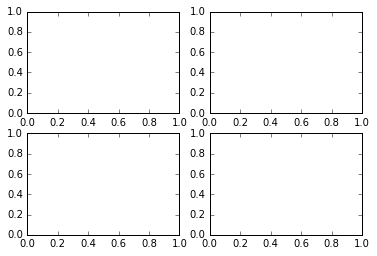

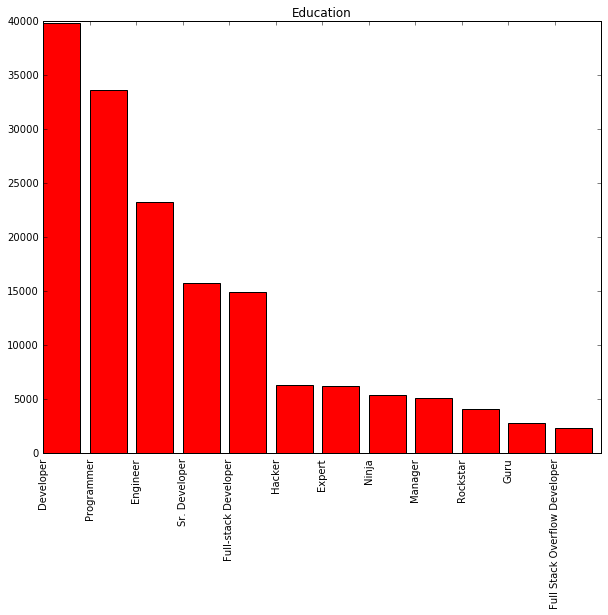

TypeError: 'NoneType' object is not iterable

In [11]:
# Create subplots here, so we can see all the columns data together

# adjusting subplots
gs = GridSpec(2,2,
              width_ratios=[1,1],
              height_ratios=[1,1])
ax1 = pl.subplot(gs[0])
ax2 = pl.subplot(gs[1])
ax3 = pl.subplot(gs[2])
ax4 = pl.subplot(gs[3])

axes = (ax1, ax2, ax3, ax4)
color = ('r', 'y', 'g', 'b')

def binary_counter(n):
    s = ""
    if n == 0: s = "00"
    while n > 0:
        s = str(1 & n) + s
        n /= 2
        
    if len(s) == 1:
        s = "0" + s
        
    return s
        

# filling in x and y data for each graph
for ax, column_name, c, n in zip(axes, large_columns[0:4], color, range(0, 4)):
    if len([int(x) for x in binary_counter(n).split()]) == 1:
        i = 0
    else:
        i, j = [int(x) for x in binary_counter(n).split()]
    x, y = plot_bernoulli_df((plot_axes(df, column_name)))
    x = range(0, len(x))
    ax.bar(x, y, color=c)
    ax[i, j].set_title('hello')
    ax.plot(x, y)

In [162]:
## target_col1 = df['open_to_new_job']
target_col2 = df['dev_environment']
target_col3 = df['employment_status']

all_answers_col1 = {}
for i in target_col1:
    if i not in all_answers_col1:
        all_answers_col1[i] = 1
    else:
        all_answers_col1[i] += 1
    
for answer, count in all_answers_col1.iteritems():
    print answer, count


nan 11650
I'm not actively looking, but I am open to new opportunities 27848
I am not interested in new job opportunities 9674
I am actively looking for a new job 6858


In [86]:
all_col2 = {}
for i, data in enumerate(target_col2):
    data = str(data).split('; ')
    
    for j in data:
        if j not in all_col2:
            all_col2[j] = 1
        else:
            all_col2[j] += 1
            
all_col2

{'Android Studio': 6073,
 'Atom': 5825,
 'Coda': 414,
 'Eclipse': 10564,
 'Emacs': 2433,
 'IPython / Jupyter': 1626,
 'IntelliJ': 7938,
 'Komodo': 379,
 'Lighttable': 143,
 'NetBeans': 3773,
 'Notepad++': 16607,
 'PhpStorm': 3437,
 'PyCharm': 3175,
 'RStudio': 917,
 'RubyMine': 805,
 'Sublime': 14434,
 'TextMate': 753,
 'Vim': 12180,
 'Visual Studio': 16580,
 'Visual Studio Code': 3371,
 'Xamarin': 934,
 'Xcode': 4822,
 'Zend': 224,
 'nan': 10317}